# STAT 7240 Text Analytics
## Final Project

**Project Description:** This project embodies the spirit of exploration and application of advanced text analysis techniques on novel datasets not covered in the course. Utilizing the FinancialPhraseBank dataset, the project aims to delve into the intricacies of financial news headlines by applying topic modeling to uncover underlying themes, sentiment analysis to gauge emotional undertones, and various classification models to categorize the data effectively. By employing word embeddings obtained from BERT and training new ones, the project seeks to unearth and map out the nuanced relationships between terms used in the financial lexicon. The ultimate goal is to construct models that can accurately predict the sentiment of financial news, providing valuable insights from the perspective of retail investors.


**Author:** Cheng-Ying Wu

In [1]:
!pip install transformers

In [2]:
# Packages Used
import pandas as pd
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Data, Extraction, and Preprocessing**

### Data Source

Sentiment Analysis for Financial News (FinancialPhraseBank)
*   **Kaggle Link:** https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news/data
*   **Data Origin:** The data originates from the FinancialPhraseBank, which is publicly available on Kaggle. The dataset specifically aims to reflect the sentiments found in financial news headlines from the perspective of a retail investor

In [3]:
# Load the data from the downloaded CSV file from Kaggle
data = pd.read_csv('/content/all-data.csv', encoding='unicode_escape', names=['Sentiment', 'Text'])
data

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


### Extraction & Preprocessing

In [4]:
# Preprocessing function for news headlines
def preprocess_headline(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower().strip()
    return text

# Tokenizing function for news headlines
def tokenize_headline(text):
    tokens = word_tokenize(text)

    # Remove stopwords
    stopwords_english = stopwords.words('english')
    tokens_cleaned = [word for word in tokens if word not in stopwords_english]
    return tokens_cleaned

In [5]:
# Preprocess and tokenize headlines
data['headline_cleaned'] = data['Text'].apply(preprocess_headline)
data['headline_tokens'] = data['headline_cleaned'].apply(tokenize_headline)

# Display the results
data.head()

,Sentiment,Text,headline_cleaned,headline_tokens
0,neutral,"According to Gran , the company has no plans t...",according to gran the company has no plans to...,"[according, gran, company, plans, move, produc..."
1,neutral,Technopolis plans to develop in stages an area...,technopolis plans to develop in stages an area...,"[technopolis, plans, develop, stages, area, le..."
2,negative,The international electronic industry company ...,the international electronic industry company ...,"[international, electronic, industry, company,..."
3,positive,With the new production plant the company woul...,with the new production plant the company woul...,"[new, production, plant, company, would, incre..."
4,positive,According to the company 's updated strategy f...,according to the company s updated strategy fo...,"[according, company, updated, strategy, years,..."


Preprocess the Sentiment column as numerical data and perform other preprocessing steps:

In [6]:
# Mapping 'neutral' to 0, 'positive' to 1, and 'negative' to 2
sentiment_mapping = {'neutral': 0, 'positive': 1, 'negative': 2}
data['sentiment_label'] = data['Sentiment'].map(sentiment_mapping)

# Additional preprocessing steps:
# Check for and handle missing values
data.dropna(inplace=True) # Remove rows with missing values
# Reset index after dropping rows to maintain consistency in the DataFrame
data.reset_index(drop=True, inplace=True)

# Additional preprocessing steps might include removing duplicates or handling outlier values if any
# Check for duplicate headlines and remove them to prevent biased EDA
data = data.drop_duplicates(subset='Text').reset_index(drop=True)

# Data is ready for EDA
data

,Sentiment,Text,headline_cleaned,headline_tokens,sentiment_label
0,neutral,"According to Gran , the company has no plans t...",according to gran the company has no plans to...,"[according, gran, company, plans, move, produc...",0
1,neutral,Technopolis plans to develop in stages an area...,technopolis plans to develop in stages an area...,"[technopolis, plans, develop, stages, area, le...",0
2,negative,The international electronic industry company ...,the international electronic industry company ...,"[international, electronic, industry, company,...",2
3,positive,With the new production plant the company woul...,with the new production plant the company woul...,"[new, production, plant, company, would, incre...",1
4,positive,According to the company 's updated strategy f...,according to the company s updated strategy fo...,"[according, company, updated, strategy, years,...",1
...,...,...,...,...,...
4833,negative,LONDON MarketWatch -- Share prices ended lower...,london marketwatch share prices ended lower i...,"[london, marketwatch, share, prices, ended, lo...",2
4834,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,rinkuskiai s beer sales fell by 65 per cent to...,"[rinkuskiai, beer, sales, fell, 65, per, cent,...",0
4835,negative,Operating profit fell to EUR 35.4 mn from EUR ...,operating profit fell to eur 354 mn from eur 6...,"[operating, profit, fell, eur, 354, mn, eur, 6...",2
4836,negative,Net sales of the Paper segment decreased to EU...,net sales of the paper segment decreased to eu...,"[net, sales, paper, segment, decreased, eur, 2...",2


## **Exploratory Data Analysis (EDA)**

In [7]:
# Basic information about the dataset
print("Basic Information about the Data:")
print(data.info())

# Descriptive statistics for the numerical columns
print("\nDescriptive Statistics:")
print(data.describe())

# Checking for missing values in the dataset
print("\nMissing Values in the Dataset:")
print(data.isnull().sum())

# Check for class balance in the 'Sentiment' column
print("\nClass Balance in 'Sentiment':")
print(data['Sentiment'].value_counts(normalize=True))

Basic Information about the Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Sentiment         4838 non-null   object
 1   Text              4838 non-null   object
 2   headline_cleaned  4838 non-null   object
 3   headline_tokens   4838 non-null   object
 4   sentiment_label   4838 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 189.1+ KB
None

Descriptive Statistics:
       sentiment_label
count      4838.000000
mean          0.531211
std           0.706271
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           2.000000

Missing Values in the Dataset:
Sentiment           0
Text                0
headline_cleaned    0
headline_tokens     0
sentiment_label     0
dtype: int64

Class Balance in 'Sentiment':
neutral     0.593634
positive    0.281521
negative    0.124845


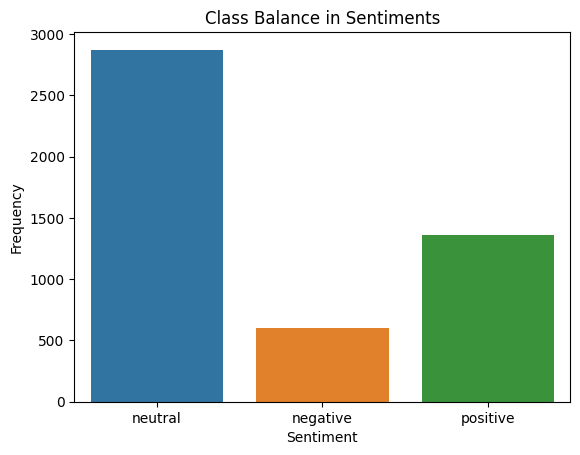

In [8]:
# Visualize the class balance
sns.countplot(x='Sentiment', data=data)
plt.title('Class Balance in Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

We can observe that:

1. The **"neutral" category has the highest frequency**, with a count significantly higher than the other two categories. This indicates that the dataset contains a majority of neutral sentiment headlines.

2. The "positive" category comes next, with a frequency that is roughly half of the neutral category. This shows a moderate representation of positive sentiment headlines in the dataset.

3. The "negative" category has the lowest frequency, indicating that negative sentiment headlines are the least represented in this dataset.

The class distribution percentages provided suggest that nearly **59% of the dataset is made up of neutral sentiment, about 28% positive sentiment, and roughly 12% negative sentiment**. The imbalance in class distribution could potentially introduce bias towards the neutral class in predictive modeling, meaning models trained on this data might be more inclined to predict an outcome as neutral. Therefore, techniques such as resampling or class weight adjustments might be necessary to mitigate bias and improve model performance for minority classes (positive and negative sentiments). Here, as we do not have much data, we use different performance metrics to evaluate the model performance to mitigate the effects of the imbalance characteristic.


Statistics about headline length:
count    4838.000000
mean       23.089913
std         9.938990
min         2.000000
25%        16.000000
50%        21.000000
75%        29.000000
max        81.000000
Name: headline_length, dtype: float64


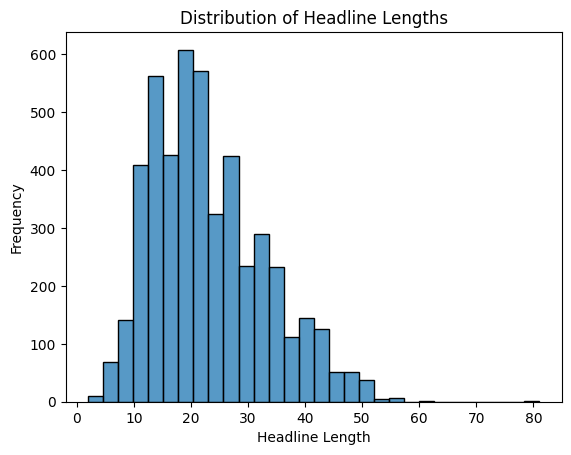

In [9]:
# Let's also look at some statistics about the text
data['headline_length'] = data['Text'].apply(lambda x: len(x.split()))
print("\nStatistics about headline length:")
print(data['headline_length'].describe())

# Visualize the distribution of headline lengths
sns.histplot(data['headline_length'], bins=30)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.show()

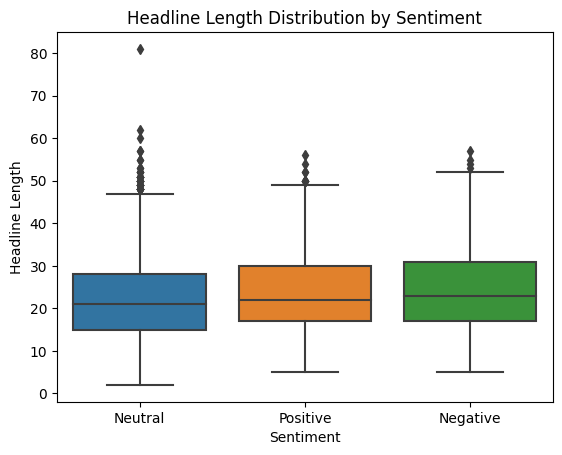

In [10]:
# Show the headline length distribution across sentiments
sns.boxplot(x='Sentiment', y='headline_length', data=data)
plt.title('Headline Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Headline Length')
plt.xticks(ticks=[0, 1, 2], labels=['Neutral', 'Positive', 'Negative'])
plt.show()

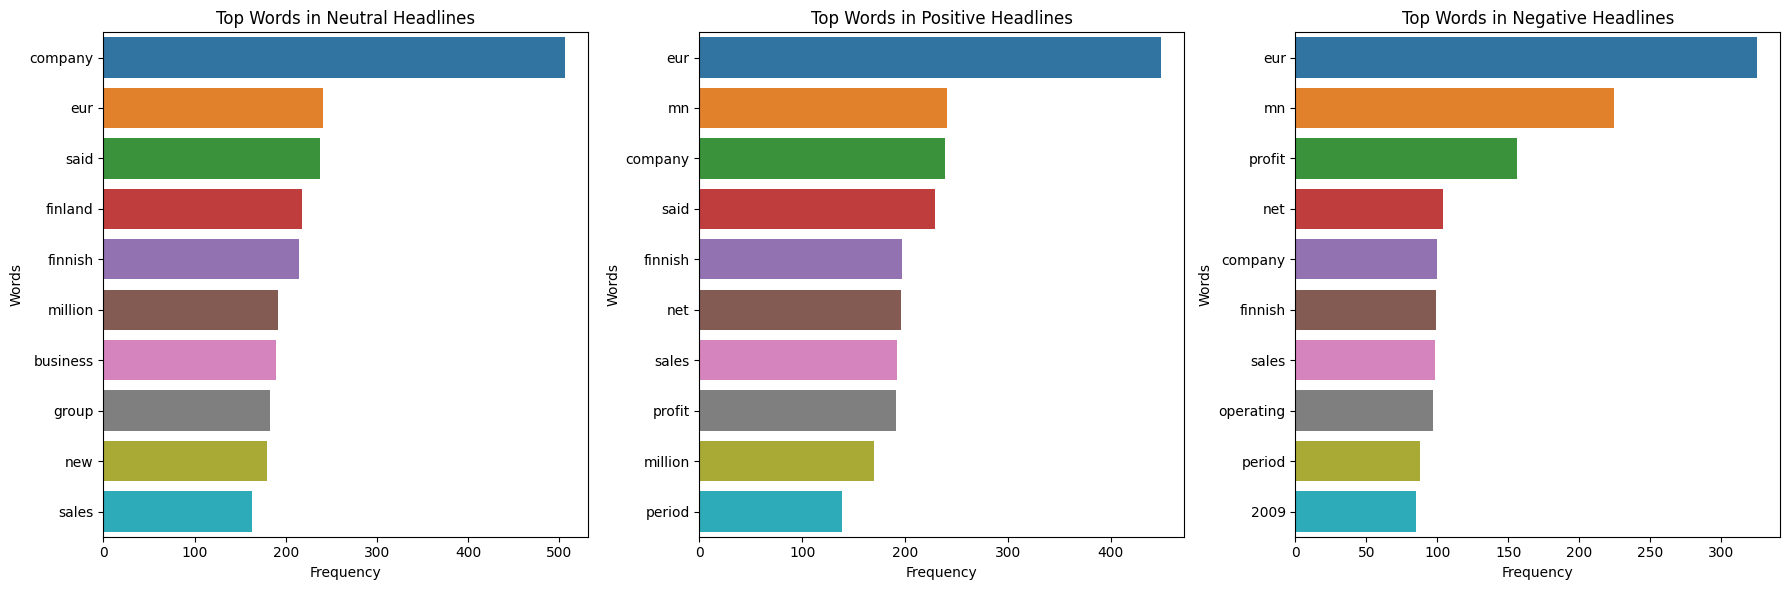

In [11]:
# Examine the most frequent words in each sentiment category
def get_top_words(tokens_list):
    all_words = [word for tokens in tokens_list for word in tokens]
    return Counter(all_words).most_common(10)

# Get the top words for each sentiment category
top_words_neutral = get_top_words(data[data['sentiment_label'] == 0]['headline_tokens'])
top_words_positive = get_top_words(data[data['sentiment_label'] == 1]['headline_tokens'])
top_words_negative = get_top_words(data[data['sentiment_label'] == 2]['headline_tokens'])

# Plot the top words
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(ax=axes[0], x=[count for word, count in top_words_neutral], y=[word for word, count in top_words_neutral])
axes[0].set_title('Top Words in Neutral Headlines')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')

sns.barplot(ax=axes[1], x=[count for word, count in top_words_positive], y=[word for word, count in top_words_positive])
axes[1].set_title('Top Words in Positive Headlines')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Words')

sns.barplot(ax=axes[2], x=[count for word, count in top_words_negative], y=[word for word, count in top_words_negative])
axes[2].set_title('Top Words in Negative Headlines')
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('Words')

plt.tight_layout()
plt.show()

The set of three bar charts compares the **top words found in financial news headlines**, categorized by sentiment: neutral, positive, and negative. Each chart is sorted by the frequency of occurrence of each word within its respective sentiment category.

1. In neutral headlines, the most frequent word is **"company,"** followed by **"eur"** (likely short for Euro, the currency), and **"said."** This indicates a focus on company-centric news and possibly financial reporting or statements in the context presumed to be neutral.

2. Positive headlines also feature **"eur"** and **"company"** as top words, suggesting that financial performance or positive news related to companies and their financial dealings in Euros are common in this sentiment category. The presence of words like **"profit" and "sales" further supports this assumption**.

3. Negative headlines have a different set of frequent words with **"eur"** still prominent but accompanied by words like **"profit," "net," and "operating,"** which could relate to financial results. The presence of "2009" might indicate that the data includes reports from a year with notable negative financial events, or it could be a specific reference point for the dataset.

Overall, while there is **some overlap in the top words across different sentiments**, certain words like "operating" and "period" are more exclusive to negative headlines, and "sales" and "profit" appear in both positive and negative, which may reflect their use in different contexts. The analysis of these word frequencies can help in understanding the common themes within financial news and assist in building sentiment analysis models.

## **Modeling + Inference**

### **Textual Data Encoding**

#### Convert to sequences using the Tokenizer and text_to_word_sequence

In [12]:
# Set the number of features as the maximum words
MAX_FEATURES = 5000

# Initialize the tokenizer with the top MAX_FEATURES words
tokenizer = Tokenizer(num_words=MAX_FEATURES)

# Fit the tokenizer on the headline tokens
tokenizer.fit_on_texts(data['headline_cleaned'])

# Convert the 'headline_cleaned' column to sequences
sequences = tokenizer.texts_to_sequences(data['headline_cleaned'])

# Get the labels
labels = data['sentiment_label'].values

# Pad the sequences to have a uniform length
MAX_LENGTH = 100
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH)

#### Dataset Splitting (train/validation/test split ratio is 80/10/10)

In [13]:
# First, split into 80% train and 20% for combined validation and testing
train_sequences, test_val_sequences, train_labels, test_val_labels = train_test_split(
    padded_sequences, labels, test_size=0.20, random_state=42)

# Now split the 20% test_val data equally into 10% test and 10% validation sets
test_sequences, val_sequences, test_labels, val_labels = train_test_split(
    test_val_sequences, test_val_labels, test_size=0.50, random_state=42)

# Verify the size of each dataset
print(f"Training set: {len(train_sequences)} samples")
print(f"Validation set: {len(val_sequences)} samples")
print(f"Testing set: {len(test_sequences)} samples")

Training set: 3870 samples
Validation set: 484 samples
Testing set: 484 samples


### **Traditional Machine Learning Modeling**

#### Modeling using Logistic Regression, Decision Tree, Random Forest, XGBoost, Bayesian, and Gradient Boosting

In [14]:
def train_evaluate_models(X_train, y_train, X_test, y_test):
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(solver='saga'),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'Bayesian': GaussianNB(),
        'Gradient Boosting': GradientBoostingClassifier()
    }

    # Dictionary to store performance metrics
    performance_metrics = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': []
    }

    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Append metrics to the dictionary
        performance_metrics['Model'].append(name)
        performance_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        performance_metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
        performance_metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
        performance_metrics['F1 Score'].append(f1_score(y_test, y_pred, average='weighted'))

    return performance_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


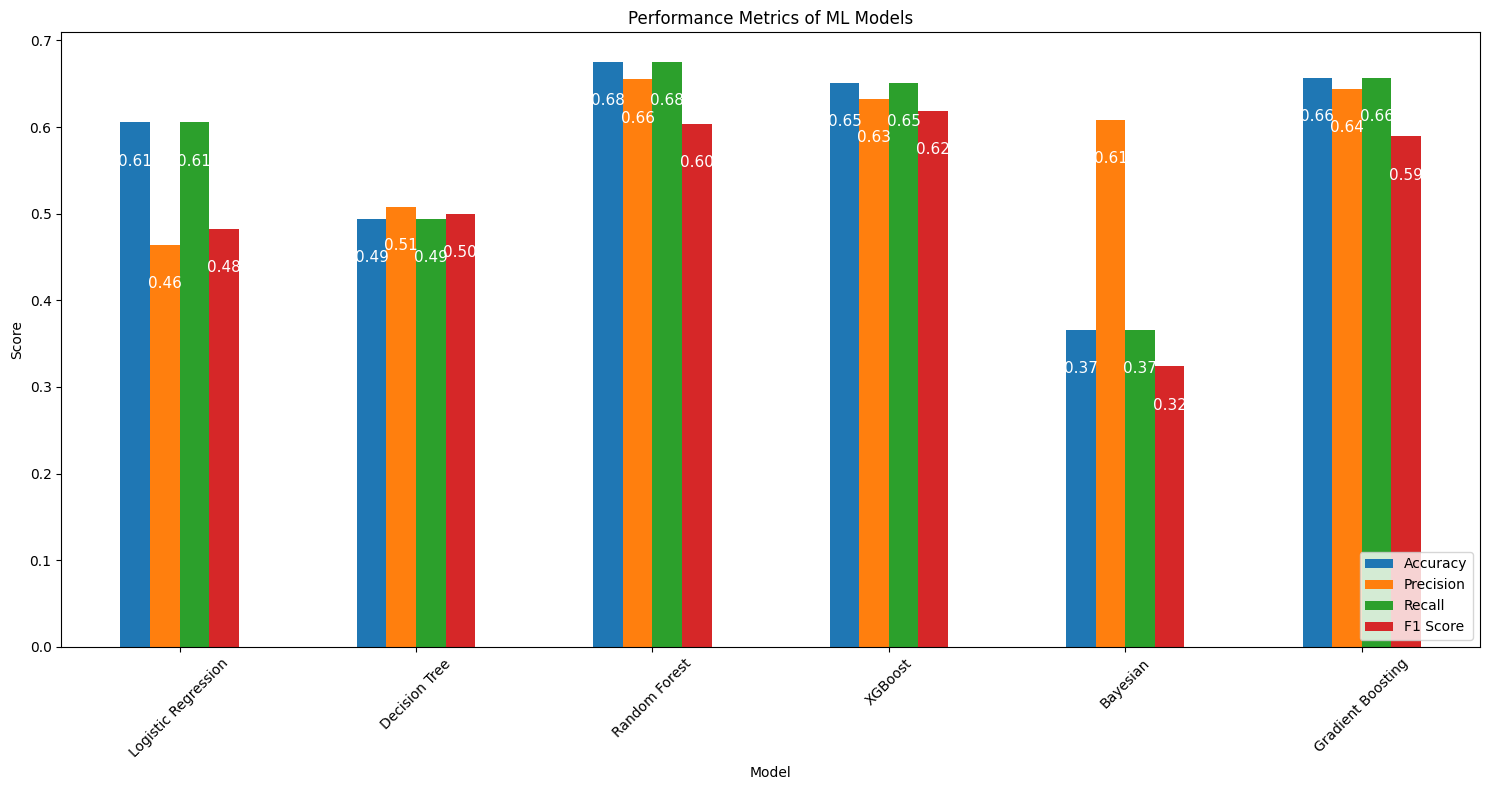

In [15]:
performance_metrics = train_evaluate_models(train_sequences, train_labels, val_sequences, val_labels)

# Plotting the performance metrics
metrics_df = pd.DataFrame(performance_metrics)
metrics_df.set_index('Model', inplace=True)

# Plot a histogram
metrics_df.plot(kind='bar', figsize=(15, 8))
plt.title('Performance Metrics of ML Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')

# After plotting the bars, iterate over them and add text labels
for i, bar in enumerate(plt.gca().patches):
    plt.gca().text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                   f'{bar.get_height():.2f}',
                   ha='center', color='w', fontsize=11)

plt.tight_layout()
plt.show()

Based on the performance metrics above for each model, we can perform the following analysis.

Given these results, we can determine that:

- **Random Forest** is the best performer in terms of accuracy and recall. However, its F1 score, which balances precision and recall, is not the highest.
- **XGBoost** follows closely in terms of accuracy and recall but has a higher F1 score than Random Forest, suggesting a better balance between precision and recall.
- **Gradient Boosting** is comparable to XGBoost in accuracy and recall and has a precision close to Random Forest, but its F1 score is slightly lower than that of XGBoost.
- **Bayesian (Naive Bayes)** has the relatively high precision, but this is likely misleading due to its very low recall and accuracy, indicating that it is not a good fit for this dataset.
- **Logistic Regression** and **Decision Tree** models perform moderately well but are outperformed by ensemble methods.

Generally speaking, the **XGBoost** model appears to offer the best balance across all metrics, making it the preferred choice in this scenario. It has high accuracy and recall, and the highest F1 score among all models, which suggests it has a good balance between precision and recall.

#### Hyperparameter tuning for **XGBoost**

In [16]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Perform grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='accuracy', cv=3, verbose=1)

# Fit the model
grid_search.fit(val_sequences, val_labels)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters on the combined training and validation set
final_model = XGBClassifier(**best_params)
final_model.fit(np.concatenate((train_sequences, val_sequences)), np.concatenate((train_labels, val_labels)))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

#### Testing the final model

In [17]:
# Predict on the test set
test_predictions = final_model.predict(test_sequences)

# Evaluate the final model
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')

# Print classification report
print(classification_report(test_labels, test_predictions))

# Print performance metrics
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")

              precision    recall  f1-score   support

           0       0.62      0.99      0.76       276
           1       0.56      0.16      0.25       144
           2       0.67      0.03      0.06        64

    accuracy                           0.62       484
   macro avg       0.62      0.39      0.36       484
weighted avg       0.61      0.62      0.52       484

Test Accuracy: 0.6157024793388429
Test Precision: 0.6088690268946265
Test Recall: 0.6157024793388429
Test F1 Score: 0.516726393947955


- **Test Accuracy (0.616)**: This indicates that the model correctly predicts the sentiment of a news headline about 61.6% of the time. While better than a random guess, there is still significant room for improvement, especially if the model is to be used in practical applications where higher accuracy may be crucial.

- **Test Precision (0.609)**: Precision measures the model's ability to label as positive only those samples that are truly positive. In this context, it means that when the model predicts a sentiment (positive, negative, or neutral), it is correct approximately 60.9% of the time.

- **Test Recall (0.616)**: Recall assesses the model's ability to find all the relevant cases within a dataset. The recall score suggests that the model is able to identify 61.6% of all relevant sentiments correctly.

- **Test F1 Score (0.517)**: The F1 score is a weighted average of precision and recall. This score is considerably lower than the accuracy, precision, and recall, which often indicates an imbalance in the precision and recall metrics. A lower F1 score suggests that there is a trade-off between precision and recall in the model, with either false positives or false negatives being more prevalent.

Overall, the model shows a **moderate performance** with relatively balanced precision and recall. However, the F1 score indicates that the model's balance between precision and recall isn't optimal, which is often more critical in practice than raw accuracy. For instance, in financial sentiment analysis, missing out on true positives (actual negative sentiment not caught) or having too many false positives (neutral or positive sentiment incorrectly labeled as negative) can lead to misinformed decisions. Therefore, it may be beneficial to further explore model adjustments, additional features, or alternative models to improve the F1 score, especially if high reliability is required for the task at hand.

### **Create Embeddings for Textual Data Using Advanced Transformer**

We can find that the model performance still has space for improvement. Thus, instead of using Tokenizer and texts_to_sequences, we can leverage state-of-the-art language representation models like **BERT** (Bidirectional Encoder Representations from Transformers) to create embeddings for textual data. BERT embeddings capture the context of each word in a sentence in a way that is sensitive to the nuances and variability of language.

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

"""Tokenization and Encoding:
Tokenize and encode the sentences as BERT expects them, with special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP])."""
def encode_sentences(sentences):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,
                            add_special_tokens=True,    # Add '[CLS]' and '[SEP]'
                            max_length=64,              # Pad & truncate all sentences
                            padding='max_length',       # Pad all to max length
                            truncation=True,            # Explicitly truncate examples to max length
                            return_attention_mask=True, # Construct attn. masks
                            return_tensors='pt',        # Return pytorch tensors
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists to tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [19]:
sentences = data['headline_cleaned'].tolist()
input_ids, attention_masks = encode_sentences(sentences)

**Extract Embeddings:** Pass the encoded sentences to BERT to obtain the embeddings. Since this step can be resource-intensive, especially for large datasets, it's often performed in batches.

In [20]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Put model in evaluation mode
model.eval()

# Initialize list to store embeddings
embeddings = []

# Encode sentences in batches
batch_size = 32
with torch.no_grad():
    for i in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[i:i+batch_size].to(device)
        batch_attention_masks = attention_masks[i:i+batch_size].to(device)
        batch_embeddings = model(batch_input_ids, attention_mask=batch_attention_masks)

        # Get the embeddings from the last hidden state
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

# Concatenate the batches
embeddings = np.concatenate(embeddings, axis=0)

#### Train and test on the XGBoost model

In [21]:
# Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# Train XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.743801652892562
Precision: 0.7341416752517211
Recall: 0.743801652892562
F1 Score: 0.7317061729725071


We can find that the XGBoost model's performance with **BERT embeddings significantly outperforms** the results obtained using the Tokenizer and texts_to_sequences approach, as evidenced by the higher values across all the evaluated metrics: accuracy, precision, recall, and F1 score.

The superior performance of the BERT-based model can be attributed to its sophisticated handling of language context, its use of pre-trained knowledge via transfer learning, and its robustness to OOV words. These factors allow BERT to create embeddings that capture deeper linguistic properties than non-contextual embeddings, resulting in better model performance for complex NLP tasks like sentiment analysis.

### **Deep Learning Modeling**

#### Create the datasets

In [22]:
# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader objects
batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

#### Define the deep learning models and the train and evaluation pipeline

In [23]:
# 'input_size' is the size of the input features and 'output_size' is the number of classes
input_size = embeddings.shape[1]
output_size = 3                   # 'neutral' to 0, 'positive' to 1, and 'negative' to 2
num_epochs = 20

# Define the MLP, LSTM, and GRU models
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.fc(x)

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.fc = nn.Linear(64, output_size)

    def forward(self, x):
        out, (hidden, _) = self.lstm(x)
        # Make sure that out has three dimensions [batch, sequence, feature]
        out = out if out.dim() == 3 else out.unsqueeze(1)
        return self.fc(out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, 64, batch_first=True)
        self.fc = nn.Linear(64, output_size)

    def forward(self, x):
        out, hidden = self.gru(x)
        # Make sure that out has three dimensions [batch, sequence, feature]
        out = out if out.dim() == 3 else out.unsqueeze(1)
        return self.fc(out[:, -1, :])

# Instantiate models
mlp_model = MLPModel()
lstm_model = LSTMModel()
gru_model = GRUModel()

In [24]:
# Training function
def train_evaluate_dl_model(model, train_data_loader, test_data_loader, num_epochs):
    # Move the model to the GPU if available
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Record losses and accuracies
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        # Training loop
        model.train()
        total_loss = 0
        for inputs, labels in train_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_data_loader)
        train_losses.append(avg_train_loss)

        # Testing loop
        model.eval()
        total_test_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in test_data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_test_loss = total_test_loss / len(test_data_loader)
        test_losses.append(avg_test_loss)
        accuracy = accuracy_score(all_labels, all_preds)
        test_accuracies.append(accuracy)
        tqdm.write(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Plot training and testing losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Train & Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1

#### Train the evaluate models

Epochs:   5%|▌         | 1/20 [00:00<00:04,  4.23it/s]

Epoch 1/20 - Train Loss: 0.9148, Test Loss: 0.8578, Accuracy: 0.6674


Epochs:  10%|█         | 2/20 [00:00<00:04,  4.12it/s]

Epoch 2/20 - Train Loss: 0.8320, Test Loss: 0.8176, Accuracy: 0.6942


Epochs:  15%|█▌        | 3/20 [00:00<00:04,  4.14it/s]

Epoch 3/20 - Train Loss: 0.7959, Test Loss: 0.7936, Accuracy: 0.7366


Epochs:  20%|██        | 4/20 [00:00<00:03,  4.12it/s]

Epoch 4/20 - Train Loss: 0.7720, Test Loss: 0.7843, Accuracy: 0.7428


Epochs:  25%|██▌       | 5/20 [00:01<00:03,  4.06it/s]

Epoch 5/20 - Train Loss: 0.7592, Test Loss: 0.7812, Accuracy: 0.7438


Epochs:  30%|███       | 6/20 [00:01<00:03,  4.09it/s]

Epoch 6/20 - Train Loss: 0.7508, Test Loss: 0.7735, Accuracy: 0.7552


Epochs:  35%|███▌      | 7/20 [00:01<00:03,  4.11it/s]

Epoch 7/20 - Train Loss: 0.7440, Test Loss: 0.7726, Accuracy: 0.7552


Epochs:  40%|████      | 8/20 [00:01<00:02,  4.04it/s]

Epoch 8/20 - Train Loss: 0.7362, Test Loss: 0.7682, Accuracy: 0.7562


Epochs:  45%|████▌     | 9/20 [00:02<00:02,  4.09it/s]

Epoch 9/20 - Train Loss: 0.7307, Test Loss: 0.7663, Accuracy: 0.7634


Epochs:  50%|█████     | 10/20 [00:02<00:02,  4.15it/s]

Epoch 10/20 - Train Loss: 0.7251, Test Loss: 0.7719, Accuracy: 0.7572


Epochs:  55%|█████▌    | 11/20 [00:02<00:02,  4.12it/s]

Epoch 11/20 - Train Loss: 0.7228, Test Loss: 0.7640, Accuracy: 0.7665


Epochs:  60%|██████    | 12/20 [00:02<00:01,  4.14it/s]

Epoch 12/20 - Train Loss: 0.7176, Test Loss: 0.7599, Accuracy: 0.7676


Epochs:  65%|██████▌   | 13/20 [00:03<00:01,  4.12it/s]

Epoch 13/20 - Train Loss: 0.7168, Test Loss: 0.7607, Accuracy: 0.7748


Epochs:  70%|███████   | 14/20 [00:03<00:01,  4.14it/s]

Epoch 14/20 - Train Loss: 0.7111, Test Loss: 0.7594, Accuracy: 0.7634


Epochs:  75%|███████▌  | 15/20 [00:03<00:01,  4.13it/s]

Epoch 15/20 - Train Loss: 0.7091, Test Loss: 0.7584, Accuracy: 0.7707


Epochs:  80%|████████  | 16/20 [00:03<00:00,  4.10it/s]

Epoch 16/20 - Train Loss: 0.7078, Test Loss: 0.7593, Accuracy: 0.7707


Epochs:  85%|████████▌ | 17/20 [00:04<00:00,  3.91it/s]

Epoch 17/20 - Train Loss: 0.7034, Test Loss: 0.7600, Accuracy: 0.7655


Epochs:  90%|█████████ | 18/20 [00:04<00:00,  3.73it/s]

Epoch 18/20 - Train Loss: 0.7008, Test Loss: 0.7567, Accuracy: 0.7696


Epochs:  95%|█████████▌| 19/20 [00:04<00:00,  3.60it/s]

Epoch 19/20 - Train Loss: 0.6972, Test Loss: 0.7547, Accuracy: 0.7696


Epochs: 100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


Epoch 20/20 - Train Loss: 0.6980, Test Loss: 0.7635, Accuracy: 0.7717


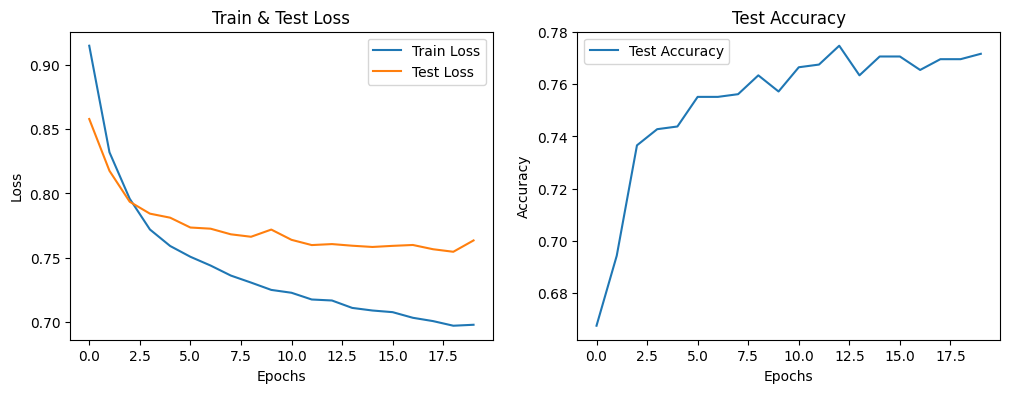

Epochs:   5%|▌         | 1/20 [00:00<00:14,  1.29it/s]

Epoch 1/20 - Train Loss: 0.8005, Test Loss: 0.6535, Accuracy: 0.7056


Epochs:  10%|█         | 2/20 [00:01<00:10,  1.79it/s]

Epoch 2/20 - Train Loss: 0.5898, Test Loss: 0.6073, Accuracy: 0.7242


Epochs:  15%|█▌        | 3/20 [00:01<00:08,  2.02it/s]

Epoch 3/20 - Train Loss: 0.5205, Test Loss: 0.5592, Accuracy: 0.7510


Epochs:  20%|██        | 4/20 [00:01<00:07,  2.25it/s]

Epoch 4/20 - Train Loss: 0.4882, Test Loss: 0.5932, Accuracy: 0.7231


Epochs:  25%|██▌       | 5/20 [00:02<00:06,  2.41it/s]

Epoch 5/20 - Train Loss: 0.4554, Test Loss: 0.5277, Accuracy: 0.7686


Epochs:  30%|███       | 6/20 [00:02<00:05,  2.56it/s]

Epoch 6/20 - Train Loss: 0.4299, Test Loss: 0.5161, Accuracy: 0.7810


Epochs:  35%|███▌      | 7/20 [00:03<00:04,  2.66it/s]

Epoch 7/20 - Train Loss: 0.4096, Test Loss: 0.5297, Accuracy: 0.7676


Epochs:  40%|████      | 8/20 [00:03<00:04,  2.77it/s]

Epoch 8/20 - Train Loss: 0.3894, Test Loss: 0.5542, Accuracy: 0.7572


Epochs:  45%|████▌     | 9/20 [00:03<00:03,  2.85it/s]

Epoch 9/20 - Train Loss: 0.3625, Test Loss: 0.5387, Accuracy: 0.7738


Epochs:  50%|█████     | 10/20 [00:03<00:03,  2.93it/s]

Epoch 10/20 - Train Loss: 0.3414, Test Loss: 0.5315, Accuracy: 0.7789


Epochs:  55%|█████▌    | 11/20 [00:04<00:03,  2.97it/s]

Epoch 11/20 - Train Loss: 0.3262, Test Loss: 0.5263, Accuracy: 0.7831


Epochs:  60%|██████    | 12/20 [00:04<00:02,  3.02it/s]

Epoch 12/20 - Train Loss: 0.2991, Test Loss: 0.5181, Accuracy: 0.7810


Epochs:  65%|██████▌   | 13/20 [00:04<00:02,  3.01it/s]

Epoch 13/20 - Train Loss: 0.2804, Test Loss: 0.5558, Accuracy: 0.7665


Epochs:  70%|███████   | 14/20 [00:05<00:02,  2.98it/s]

Epoch 14/20 - Train Loss: 0.2603, Test Loss: 0.5405, Accuracy: 0.7779


Epochs:  75%|███████▌  | 15/20 [00:05<00:01,  3.02it/s]

Epoch 15/20 - Train Loss: 0.2399, Test Loss: 0.5530, Accuracy: 0.7665


Epochs:  80%|████████  | 16/20 [00:05<00:01,  3.06it/s]

Epoch 16/20 - Train Loss: 0.2224, Test Loss: 0.5504, Accuracy: 0.7748


Epochs:  85%|████████▌ | 17/20 [00:06<00:00,  3.05it/s]

Epoch 17/20 - Train Loss: 0.2054, Test Loss: 0.5589, Accuracy: 0.7820


Epochs:  90%|█████████ | 18/20 [00:06<00:00,  3.07it/s]

Epoch 18/20 - Train Loss: 0.1790, Test Loss: 0.5605, Accuracy: 0.7779


Epochs:  95%|█████████▌| 19/20 [00:06<00:00,  3.09it/s]

Epoch 19/20 - Train Loss: 0.1659, Test Loss: 0.5610, Accuracy: 0.7727


Epochs: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


Epoch 20/20 - Train Loss: 0.1532, Test Loss: 0.5789, Accuracy: 0.7851


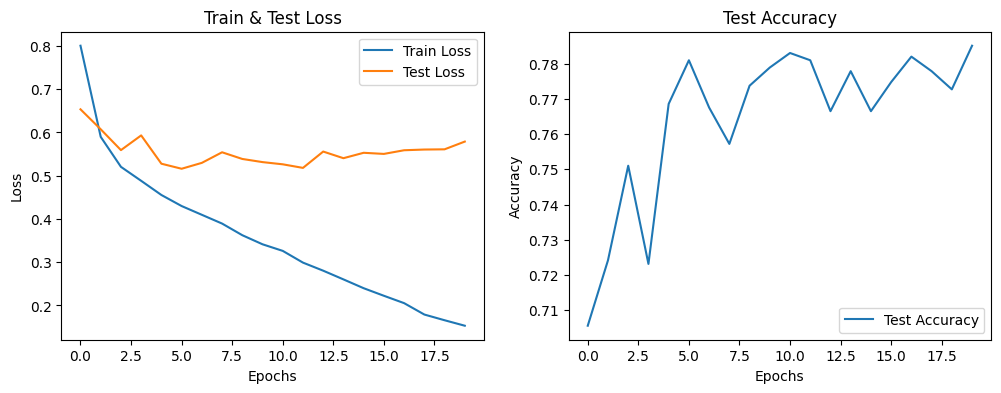

Epochs:   5%|▌         | 1/20 [00:00<00:06,  3.00it/s]

Epoch 1/20 - Train Loss: 0.7727, Test Loss: 0.6382, Accuracy: 0.7087


Epochs:  10%|█         | 2/20 [00:00<00:05,  3.04it/s]

Epoch 2/20 - Train Loss: 0.5747, Test Loss: 0.5693, Accuracy: 0.7397


Epochs:  15%|█▌        | 3/20 [00:00<00:05,  3.10it/s]

Epoch 3/20 - Train Loss: 0.5107, Test Loss: 0.5386, Accuracy: 0.7665


Epochs:  20%|██        | 4/20 [00:01<00:05,  3.11it/s]

Epoch 4/20 - Train Loss: 0.4737, Test Loss: 0.5444, Accuracy: 0.7417


Epochs:  25%|██▌       | 5/20 [00:01<00:04,  3.07it/s]

Epoch 5/20 - Train Loss: 0.4490, Test Loss: 0.5277, Accuracy: 0.7583


Epochs:  30%|███       | 6/20 [00:01<00:04,  3.05it/s]

Epoch 6/20 - Train Loss: 0.4197, Test Loss: 0.5367, Accuracy: 0.7717


Epochs:  35%|███▌      | 7/20 [00:02<00:04,  3.04it/s]

Epoch 7/20 - Train Loss: 0.3974, Test Loss: 0.5151, Accuracy: 0.7758


Epochs:  40%|████      | 8/20 [00:02<00:03,  3.06it/s]

Epoch 8/20 - Train Loss: 0.3758, Test Loss: 0.5386, Accuracy: 0.7645


Epochs:  45%|████▌     | 9/20 [00:02<00:03,  3.07it/s]

Epoch 9/20 - Train Loss: 0.3558, Test Loss: 0.5519, Accuracy: 0.7645


Epochs:  50%|█████     | 10/20 [00:03<00:03,  3.09it/s]

Epoch 10/20 - Train Loss: 0.3484, Test Loss: 0.5819, Accuracy: 0.7500


Epochs:  55%|█████▌    | 11/20 [00:03<00:02,  3.06it/s]

Epoch 11/20 - Train Loss: 0.3355, Test Loss: 0.5680, Accuracy: 0.7634


Epochs:  60%|██████    | 12/20 [00:03<00:02,  3.07it/s]

Epoch 12/20 - Train Loss: 0.2985, Test Loss: 0.5377, Accuracy: 0.7789


Epochs:  65%|██████▌   | 13/20 [00:04<00:02,  2.92it/s]

Epoch 13/20 - Train Loss: 0.2750, Test Loss: 0.5865, Accuracy: 0.7614


Epochs:  70%|███████   | 14/20 [00:04<00:02,  2.74it/s]

Epoch 14/20 - Train Loss: 0.2639, Test Loss: 0.5673, Accuracy: 0.7686


Epochs:  75%|███████▌  | 15/20 [00:05<00:01,  2.67it/s]

Epoch 15/20 - Train Loss: 0.2353, Test Loss: 0.5475, Accuracy: 0.7831


Epochs:  80%|████████  | 16/20 [00:05<00:01,  2.64it/s]

Epoch 16/20 - Train Loss: 0.2097, Test Loss: 0.5689, Accuracy: 0.7779


Epochs:  85%|████████▌ | 17/20 [00:05<00:01,  2.58it/s]

Epoch 17/20 - Train Loss: 0.2098, Test Loss: 0.5927, Accuracy: 0.7789


Epochs:  90%|█████████ | 18/20 [00:06<00:00,  2.54it/s]

Epoch 18/20 - Train Loss: 0.1824, Test Loss: 0.5739, Accuracy: 0.7738


Epochs:  95%|█████████▌| 19/20 [00:06<00:00,  2.49it/s]

Epoch 19/20 - Train Loss: 0.1644, Test Loss: 0.5761, Accuracy: 0.7851


Epochs: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


Epoch 20/20 - Train Loss: 0.1492, Test Loss: 0.5905, Accuracy: 0.7872


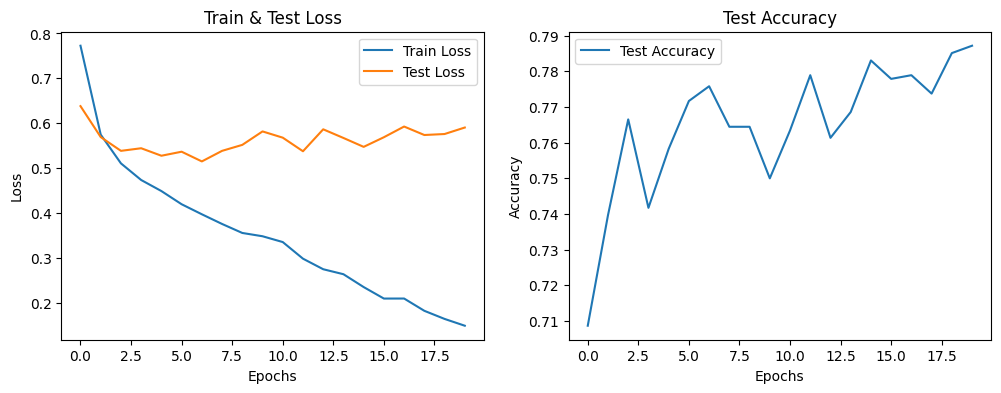

In [25]:
# Train and evaluate MLP
mlp_metrics = train_evaluate_dl_model(mlp_model, train_data_loader, test_data_loader, num_epochs)

# Train and evaluate LSTM
lstm_metrics = train_evaluate_dl_model(lstm_model, train_data_loader, test_data_loader, num_epochs)

# Train and evaluate GRU
gru_metrics = train_evaluate_dl_model(gru_model, train_data_loader, test_data_loader, num_epochs)

Some analysis for LSTM & GRU graphs:
* **Train & Test Loss Graph**: This graph shows that the training loss decreases steadily as the number of epochs increases, indicating that the model is learning from the training data over time. However, the testing loss remains relatively flat after an initial decrease, suggesting that the model might not be improving its performance on the test data as much after the initial learning phase. This could be a sign of overfitting, where the model is learning the training data too well but is not generalizing effectively to new, unseen data.

* **Test Accuracy Graph**: The test accuracy fluctuates as the number of epochs increases, but overall, there is an upward trend. This suggests that the model is getting better at making correct predictions on the test dataset over time. However, the fluctuations indicate that the model's learning is not entirely stable, which could be due to a variety of factors such as the complexity of the model, the nature of the data, or the learning rate.

Overall, the model seems to be learning and improving in terms of accuracy on the test set, but the discrepancy between the training loss and testing loss could be a concern that needs to be addressed, possibly by implementing techniques to reduce overfitting such as regularization, dropout, or by collecting more diverse training data.

#### Plot the performance

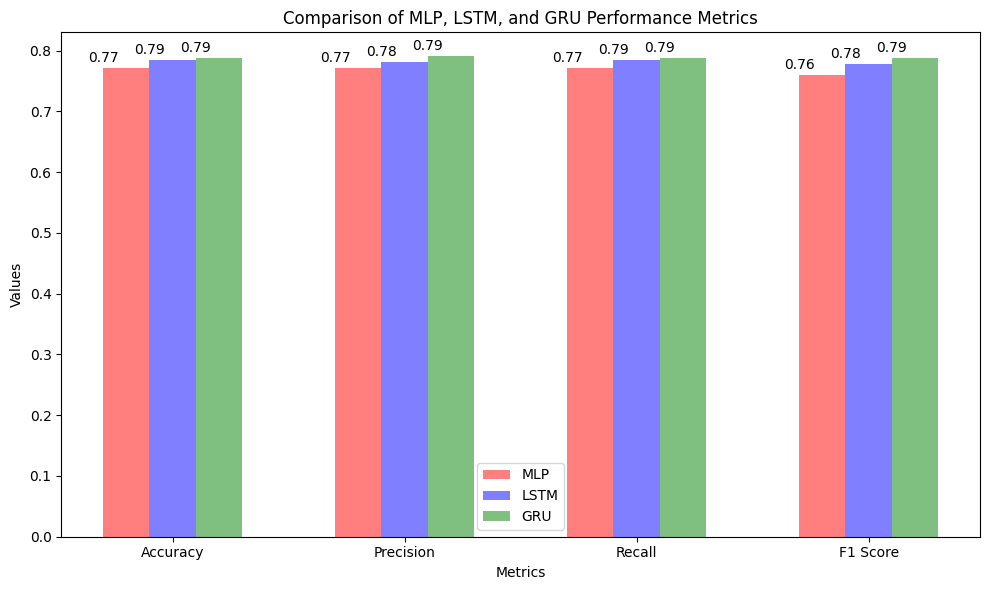

In [26]:
# Labels for the metrics
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Values for each model
mlp_values = list(mlp_metrics)
lstm_values = list(lstm_metrics)
gru_values = list(gru_metrics)

# Setting the positions and width for the bars
pos = np.arange(len(labels))
bar_width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(pos, mlp_values, bar_width, label='MLP', alpha=0.5, color='red')
plt.bar(pos + bar_width, lstm_values, bar_width, label='LSTM', alpha=0.5, color='blue')
plt.bar(pos + bar_width * 2, gru_values, bar_width, label='GRU', alpha=0.5, color='green')

# Adding the values on top of the bars
for i in range(len(labels)):
    plt.text(i - bar_width/2, mlp_values[i] + 0.01, f'{mlp_values[i]:.2f}', ha='center')
    plt.text(i + bar_width/2, lstm_values[i] + 0.01, f'{lstm_values[i]:.2f}', ha='center')
    plt.text(i + bar_width * 1.5, gru_values[i] + 0.01, f'{gru_values[i]:.2f}', ha='center')

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of MLP, LSTM, and GRU Performance Metrics')
plt.xticks(pos + bar_width, labels)
plt.legend()
plt.tight_layout()
plt.show()

From the performance metrics, it is evident that both **LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit)** models **exhibit superior performance** compared to the MLP (Multi-Layer Perceptron) model and the traditional ML models. This enhanced performance can be attributed to the fact that LSTM and GRU are designed to **capture temporal dependencies and relationships in sequential data**, which are prevalent in tasks like sentiment analysis of text. They effectively overcome the challenge of long-term dependencies, a limitation often encountered in simpler architectures like MLP.

Between LSTM and GRU, although both show comparable performance, **GRU has a distinct advantage in terms of training efficiency**. GRU's architecture is less complex than LSTM as it uses fewer parameters. This simplicity leads to faster training times while still maintaining the ability to capture temporal dynamics effectively. Given the balance between performance and computational efficiency, **GRU emerges as the more practical choice for our final model**. This decision is especially beneficial in scenarios where model training time and resource utilization are critical considerations.

### **Final Model**
The chosen model is a **Gated Recurrent Unit (GRU)** neural network which utilizes BERT embeddings as input. GRUs are a type of recurrent neural network (RNN) that can capture dependencies in sequential data, making them suitable for text analysis tasks like sentiment classification. The **BERT embeddings** serve as the independent variables, providing a rich, context-aware numerical representation of the text data from the **'headline_cleaned' column**. The dependent variable is the sentiment of the financial headlines, which the model predicts as one of three classes: neutral, positive, or negative. The GRU model learns to map the input embeddings to the correct sentiment class by adjusting the weights of its network during training. This process enables the model to infer the underlying sentiment from the structure and context encapsulated within the financial headlines.

## **Summary & Next Steps**

**Summary of Modeling Results:**

The modeling experiments have shown that the use of different encoding techniques can have a substantial impact on the performance of predictive models. The XGBoost model, coupled with Tokenizer and texts_to_sequences encoding, yielded moderate results with an accuracy and recall of approximately 61.57% and a slightly lower F1 score of 51.67%. In contrast, **the GRU model, which utilized BERT embeddings for text encoding**, significantly outperformed the XGBoost model, achieving a consistent **accuracy, precision, recall, and F1 score of 79%**. The improvement with GRU could be attributed to BERT's sophisticated understanding of language context and nuances, especially beneficial for the complexity of financial texts.

**Next Steps:**

To enhance the GRU model further, the following steps are recommended:

1. **Adding More Hidden Layers**: Introduce additional hidden layers to the GRU model to capture more complex relationships within the data.

2. **Hyperparameter Tuning**: Experiment with different hyperparameters such as learning rate, batch size, and number of GRU units to optimize model performance.

3. **Customized Financial Embeddings**: Explore domain-specific embeddings like FinBERT, which is trained on financial texts, for potentially improved semantic understanding.

4. **Model Stabilization**: Implement techniques like dropout, batch normalization, or gradient clipping to make the learning process more stable and to mitigate overfitting.

5. **Extended Validation**: Validate the model using a more extensive range of financial texts to ensure robustness and generalizability.

By focusing on these areas, there is potential to further refine the model's predictive accuracy and ensure that it is robust and generalizable across various financial contexts.